In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1)

### Generate data

In [3]:
def generate_normal_series(number, mean):
    data = []
    labels = []
    for i in range(number):
        x = []
        label = []
        x_prev = 0
        coef = 0.75
        length = scipy.stats.randint.rvs(50, 200)
        for l in range(length):
            x_curr = coef*x_prev + (1 - coef)*norm.rvs(loc=mean, scale=1)
            x.append(x_curr)
            x_prev = x_curr
            label.append(0)
        data.append(np.asarray(x))
        labels.append(np.asarray(label))
    return data, labels

In [4]:
number_normal = 5000
data_normal, labels_normal = generate_normal_series(number_normal, 0)

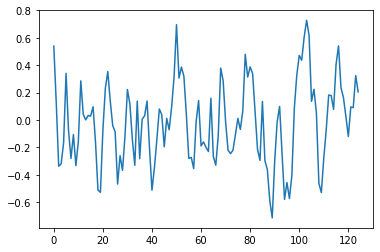

In [5]:
plt.plot(data_normal[0])

In [6]:
def generate_anomaly_series(number, mean_old, mean_new):
    data = []
    labels = []
    for i in range(number):
        x = []
        label = []
        x_prev = 0
        coef = 0.75
        length = scipy.stats.randint.rvs(50, 200)
        chane_point = scipy.stats.randint.rvs(10, length-20)
        for l in range(length):
            if l < chane_point:
                x_curr = coef*x_prev + (1 - coef)*norm.rvs(loc=mean_old, scale=1)
                label.append(0)
                
            else:
                x_curr = coef*x_prev + (1 - coef)*norm.rvs(loc=mean_new, scale=1)
                label.append(1)
            x.append(x_curr)
            x_prev = x_curr
        data.append(np.asarray(x))
        labels.append(np.asarray(label))
    return data, labels

In [7]:
number_anomaly = 200
data_anomaly, labels_anomaly = generate_anomaly_series(number_anomaly, 0, 5)

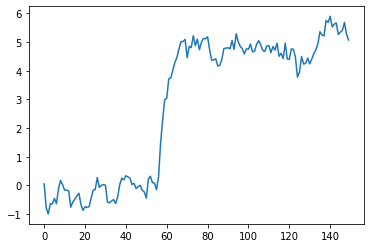

In [8]:
plt.plot(data_anomaly[0])

In [9]:
all_ts_data = np.asarray(data_normal + data_anomaly)
all_labels = np.asarray(labels_normal + labels_anomaly)

In [10]:
ts_train, ts_val, label_train, label_val = train_test_split(all_ts_data, all_labels, 
                                                            test_size=0.25, shuffle=True,
                                                            random_state=42)

In [11]:
test_number_normal = 200
test_data_normal, test_labels_normal = generate_normal_series(test_number_normal, 0)

test_number_anomaly = 100
test_data_anomaly, test_labels_anomaly = generate_anomaly_series(test_number_anomaly, 0, 5)

test_data = np.asarray(test_data_normal + test_data_anomaly)
test_labels = np.asarray(test_labels_normal + test_labels_anomaly)

In [12]:
def create_sequences(ts, label, tw):
    inout_seq = []
    for t in range(len(ts)):
        curr_ts = torch.FloatTensor(ts[t]).view(-1)
        curr_label = torch.IntTensor(label[t]).view(-1)
        for i in range(len(curr_ts) - tw):
            train_seq = curr_ts[i:i+tw]
            train_label = curr_label[i:i+tw]
            inout_seq.append((train_seq ,train_label))
    return inout_seq

### Experiment №2. 
Each moment of time is corresponded to label at the end. Use LSTM and CustomLoss()

#### Loss function

In [13]:
def loss_delay_detection_2(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0)
    loss = torch.arange(1, n+1) * p_slice * cumprod
    loss = torch.sum(loss)
    return loss


def loss_delay_detection(p_slice, w):
    n = p_slice.size(0)
    prod = torch.ones(n)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0)
    loss = torch.arange(1, n+1) * p_slice * cumprod  + (w + 1)*torch.prod(prod[1:])*(1 - p_slice[-1])
    loss = torch.sum(loss)
    return loss

def loss_false_alarms_i(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0)
    loss = p_slice * cumprod
    loss = torch.sum(loss)
    return loss

def loss_false_alarms(p_slice):
    length = len(p_slice)
    loss = 0
    
    start_ind = 0
    end_ind = 0
    
    while end_ind < length:
        start_ind = end_ind - 1
        if start_ind < 0:
            start_ind = 0
        end_ind = np.random.randint(start_ind, length + 2)
        if end_ind == start_ind:
            end_ind = end_ind + 1
        loss += 1 - loss_delay_detection_2(p_slice[start_ind: end_ind + 1])    
    loss += 1 - loss_delay_detection_2(p_slice[start_ind: length])            
    loss = torch.sum(loss)
    return loss

In [14]:
def loss_false_alarms_i(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0)
    loss = p_slice * cumprod
    print(loss)
    #loss = torch.sum(loss)
    return loss, prod, cumprod

In [15]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        loss = torch.zeros(labels.size(0))
        for i, label in enumerate(labels):

            ind = torch.where(label != label[0])[0]
            if ind.size()[0] == 0:
                loss[i] = beta*loss_false_alarms(outputs[i, :]) + (1 - w) 
            else:
                w = 16
                alpha = 1000
                loss[i] = alpha*loss_delay_detection(outputs[i, ind[0]: ind[0] + w], w) + 0.1*loss_false_alarms(outputs[i, :ind[0]])
        #print('Labels:', labels)
        #print('Loss:', loss)
        loss = torch.mean(loss)
        #print(loss)
        return loss

In [16]:
# input data parameters
input_size = 64
output_size = 64

# model hyperparameters
batch_size = 128
hidden_dim = 10
n_layers = 2
num_workers = 1
learning_rate = 1e-3

In [17]:
# prepare data in right format for LSTM

train_inout_seq = create_sequences(ts_train, label_train, input_size)
test_inout_seq = create_sequences(test_data, test_labels, input_size)
val_inout_seq = create_sequences(ts_val, label_val, input_size)

train_inout_seq = train_inout_seq[:-(len(train_inout_seq)%batch_size)]
test_inout_seq = test_inout_seq[:-(len(test_inout_seq)%batch_size)]
val_inout_seq = val_inout_seq[:-(len(val_inout_seq)%batch_size)]

train_loader = DataLoader(train_inout_seq, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_inout_seq, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_inout_seq, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [18]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.linear = nn.Linear(hidden_dim, output_size)
        self.activation = nn.Sigmoid()
        
    def forward(self, input_seq, hidden):
        batch_size = input_seq.size(0)
        lstm_out, hidden = self.lstm(input_seq[:, None, :], hidden)        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)        

        out = self.dropout(lstm_out)
        out = self.linear(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [19]:
device = torch.device("cpu")

In [20]:
model = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = CustomLoss()
loss_function = torch.nn.BCELoss()

In [21]:
epochs = 5
print_every = 200
valid_loss_min = np.Inf

loss_list = []
acc_list = []
counter = 0
model.train()

for i in range(epochs):
    
    for inputs, labels in tqdm(train_loader):
        counter += 1
        h = model.init_hidden(batch_size)
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)        
        output, h = model(inputs, h)
        loss = loss_function(output.squeeze(), labels.float())
        loss_list += [loss.clone().detach()]
        accuracy = (output > 0.5).long() == labels
        acc_list += [accuracy.detach().float().mean()]
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if counter%print_every == 0:
            val_losses = []
            val_outputs = []
            model.eval()
            for val_inputs, val_labels in val_loader:
                val_h = model.init_hidden(batch_size)
                val_h = tuple([each.data for each in val_h])
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                
                val_out, val_h = model(val_inputs, val_h)
                val_loss = loss_function(val_out.squeeze(), val_labels.float())
                val_losses.append(val_loss.item())
                val_outputs += [val_out.clone().detach()]
                
            val_outputs_one = torch.cat(val_outputs, 0)
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
        

Epoch: 1/5... Step: 200... Loss: 0.376144... Val Loss: 0.334401



Epoch: 2/5... Step: 400... Loss: 0.204296... Val Loss: 0.135063



Epoch: 3/5... Step: 600... Loss: 0.165561... Val Loss: 0.089702



Epoch: 4/5... Step: 800... Loss: 0.124203... Val Loss: 0.073870
Epoch: 4/5... Step: 1000... Loss: 0.095126... Val Loss: 0.066069



Epoch: 5/5... Step: 1200... Loss: 0.078086... Val Loss: 0.060835



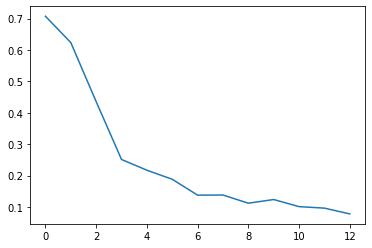

In [22]:
plt.plot(loss_list[::100])

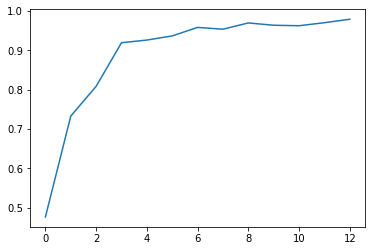

In [23]:
plt.plot(acc_list[::100])

In [24]:
test_loss_list = []
test_acc_list = []
test_pr_list = []

model.eval()
for test_inputs, test_labels in test_loader:
    test_h = model.init_hidden(batch_size)
    test_h = tuple([each.data for each in test_h])
    test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
    test_output, test_h = model(test_inputs, test_h)
    test_loss = loss_function(test_output.squeeze(), test_labels.float())
    test_loss_list += [test_loss.clone().detach()]
    
    accuracy = (test_output > 0.5).long() == test_labels
    #pr_auc = average_precision_score(test_labels.detach().numpy(), test_output.detach().numpy())
    test_acc_list += [accuracy.detach().float().mean()]
    #test_pr_list += [pr_auc]
    
print("Test loss: {:.3f}".format(np.mean(test_loss_list)))
print("Test accuracy: {:.3f}%".format(np.mean(test_acc_list)))
#print("Test PR_AUC: {:.3f}%".format(np.mean(test_pr_list)))

Test loss: 0.070
Test accuracy: 0.973%


In [25]:
test_labels[30:40]

tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

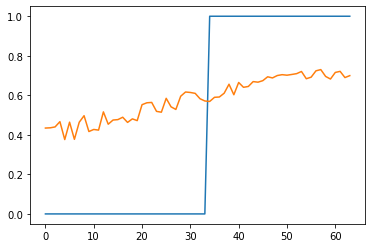

In [32]:
ind = 37
plt.plot(test_labels[ind].detach().numpy())
plt.plot(test_output[ind].detach().numpy())